# Imports

In [64]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import time
from datetime import datetime
from typing import Dict, List, Optional
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from typing import List, Dict, Tuple, Set
import json
from sklearn.metrics import r2_score


# Data Cleaning and Transformation

In [65]:
class ReadData:
    def __init__(self, data_path: Optional[str] = None, feedback_store: Optional[str] = None):
        # Initialize feedback storage
        self.feedback_store = feedback_store or 'recommendation_data/feedback.csv'
        self.data_path = data_path or 'clean_movies_data.csv'
        self._init_feedback_store()

    def _init_feedback_store(self):
        """Initialize feedback storage"""
        if not Path(self.feedback_store).exists():
            pd.DataFrame(columns=[
                'user_id', 'item_id', 'rating', 'user_movie_tags', 'timestamp', 'recommendation_type'
            ]).to_csv(self.feedback_store, index=False)

    def _read_movies_data(self):
        """Read movies data"""
        df_return = pd.read_csv(self.data_path)
        df_return.columns = ['user_id', 'item_id', 'rating', 'user_movie_tags', 'title', 'genres', 'year']
        return df_return
    
    def _read_feedback_data(self):
        return pd.read_csv(self.feedback_store)
    
    def _cat_ids(self, df: pd.DataFrame, id: str) -> pd.DataFrame:
        """Categorize user and item ids."""
        df[id] = pd.Categorical(df[id])
        df[id] = df[id].cat.codes
        return df
    
    def read_and_update_data(self):
        if len(self._read_feedback_data()) == 0:
            df_return = self._read_movies_data()
            df_return = self._cat_ids(df_return, 'user_id')
            df_return = self._cat_ids(df_return, 'item_id')
            return df_return
        else:
            df_movies = self._read_movies_data()
            df_feedback = self._read_feedback_data()    
            df_feedback_enriched = pd.merge(df_feedback.drop(columns=['timestamp', 'recommendation_type']), 
                                            df_movies[['item_id', 'title', 'genres', 'year']], 
                                            on='item_id', 
                                            how='left').drop_duplicates()
            df_return = pd.concat([df_movies, df_feedback_enriched], ignore_index=True)
            df_return = self._cat_ids(df_return, 'user_id')
            df_return = self._cat_ids(df_return, 'item_id')
            return df_return
        
    def transform_items_df(df):
        df_items = df[['item_id', 'title', 'genres', 'year', 'user_movie_tags']].copy()
        tag_counts = df_items.groupby('item_id')['user_movie_tags'].agg(lambda x: dict(Counter(x))).reset_index()
        unique_movies = df_items.drop_duplicates(subset=['item_id']).drop(columns=['user_movie_tags'])
        df_return = pd.merge(unique_movies, tag_counts, on='item_id')
        return df_return
    
    def transform_user_df(df):
        """Transform user interactions into aggregated user profiles."""
        df_user = df[['user_id', 'item_id', 'rating', 'user_movie_tags']].copy()
        user_profiles = {}
        for user_id in df_user['user_id'].unique():
            user_data = df_user[df_user['user_id'] == user_id]
            
            # Aggregate ratings
            rating_stats = {
                'avg_rating': user_data['rating'].mean(),
                'rating_std': user_data['rating'].std(),
                'num_ratings': len(user_data),
                'rating_distribution': dict(Counter(user_data['rating']))
            }
            
            # Aggregate movie tags
            tag_counts = dict(Counter(user_data['user_movie_tags'].explode()))
            
            # Create user profile
            user_profiles[user_id] = {
                'user_id': user_id,
                'rating_stats': rating_stats,
                'tag_preferences': tag_counts,
                'rated_movies': user_data['item_id'].tolist()
            }
        
        return pd.DataFrame.from_dict(user_profiles, orient='index')


In [66]:
df = ReadData().read_and_update_data()
df.columns = ['user_id', 'item_id', 'rating', 'user_movie_tags', 'title', 'genres', 'year']
items_df = ReadData.transform_items_df(df)
user_interactions_df = ReadData.transform_user_df(df)

In [67]:
class EmbeddingGenerator:
    def __init__(self):
        # self.genre_vectorizer = TfidfVectorizer()
        # self.tag_vectorizer = TfidfVectorizer()
        self.scaler = StandardScaler()

        self.text_model = SentenceTransformer('all-MiniLM-L6-v2')
        # self.scaler = MinMaxScaler()
        self.genre_vectorizer = TfidfVectorizer()
        self.tag_vectorizer = TfidfVectorizer()
        
    def _process_tag_dictionary(self, tag_dicts):
        """Convert list of tag dictionaries to a frequency matrix."""
        # Get all unique tags
        all_tags = set()
        for tag_dict in tag_dicts:
            all_tags.update(tag_dict.keys())
        all_tags = sorted(list(all_tags))
        
        # Create matrix of tag frequencies
        tag_matrix = np.zeros((len(tag_dicts), len(all_tags)))
        for i, tag_dict in enumerate(tag_dicts):
            for j, tag in enumerate(all_tags):
                tag_matrix[i, j] = tag_dict.get(tag, 0)
        
        # Normalize the frequencies
        row_sums = tag_matrix.sum(axis=1, keepdims=True)
        tag_matrix = np.divide(tag_matrix, row_sums, where=row_sums!=0)
        
        return tag_matrix
    
    def create_item_embeddings(self, items_df):
        """Generate embeddings for items using various features."""
        # 1. Generate text embeddings for titles
        title_embeddings = self.text_model.encode(items_df['title'].tolist())
        
        # 2. Process genres
        genre_embeddings = self.genre_vectorizer.fit_transform(items_df['genres']).toarray()
        
        # 3. Process year
        years = self.scaler.fit_transform(items_df[['year']]).reshape(-1)
        
        # 4. Process movie tags - now using the dictionary format
        tag_matrix = self._process_tag_dictionary(items_df['user_movie_tags'].tolist())
        
        # 5. Combine all embeddings
        combined_embeddings = np.hstack([
            title_embeddings,
            genre_embeddings,
            tag_matrix,
            years.reshape(-1, 1)
        ])
        
        return combined_embeddings
    
    def create_user_embeddings(self, user_profiles_df):
        """Generate embeddings for users based on their aggregated profiles."""
        
        # 1. Process rating statistics
        rating_features = np.column_stack([
            user_profiles_df['rating_stats'].apply(lambda x: x['avg_rating']),
            user_profiles_df['rating_stats'].apply(lambda x: x['rating_std']),
            user_profiles_df['rating_stats'].apply(lambda x: x['num_ratings'])
        ])
        
        # 2. Process tag preferences
        # Create a vocabulary of all tags
        all_tags = set()
        for tags in user_profiles_df['tag_preferences']:
            all_tags.update(tags.keys())
        
        # Create tag frequency matrix
        tag_matrix = np.zeros((len(user_profiles_df), len(all_tags)))
        for i, tags in enumerate(user_profiles_df['tag_preferences']):
            for j, tag in enumerate(all_tags):
                tag_matrix[i, j] = tags.get(tag, 0)
        
        # Normalize tag frequencies
        tag_matrix = tag_matrix / (tag_matrix.sum(axis=1, keepdims=True) + 1e-10)
        
        # 3. Combine all features
        user_embeddings = np.hstack([
            rating_features,
            tag_matrix
        ])
        
        return user_embeddings

In [ ]:
embedding_generator = EmbeddingGenerator()
# Generate item embeddings
item_embeddings = embedding_generator.create_item_embeddings(items_df)
# Generate user embeddings
user_embeddings = embedding_generator.create_user_embeddings(user_interactions_df)

c:\Users\Pedro Alves\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Modelling

In [69]:
class EnhancedRecommendationPreComputer:
    def __init__(self, 
                 items_df: pd.DataFrame,
                 user_profiles_df: pd.DataFrame,
                 user_embeddings: np.ndarray,
                 item_embeddings: np.ndarray,
                 user_feedback_df: Optional[pd.DataFrame] = None,
                 user_demographic_df: Optional[pd.DataFrame] = None):
        """Initialize recommendation computer"""
        self.items_df = items_df
        self.user_profiles_df = user_profiles_df
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
        self.user_feedback_df = user_feedback_df
        self.user_demographic_df = user_demographic_df
        
        # Configuration
        self.content_weight = 0.3
        self.collaborative_weight = 0.7
        self.diversity_weight = 0.05
        self.base_score = 0.05
        self.n_precomputed_recs = 100
        self.similar_users = 20

        # self.content_weight = 0.2
        # self.collaborative_weight = 0.7
        # self.diversity_weight = 0.05
        # self.base_score = 0.05
        # self.n_precomputed_recs = 100
        # self.similar_users = 20
        
        # Calculate dimensions
        self.user_tag_start = 3  # After rating stats (mean, std, count)
        self.item_tag_start = 384 + 20  # After title embedding (384) and approximate genre embedding (20)
        
        # Initialize computations
        self._compute_genre_representation()
        self._compute_item_metrics()
        
        print(f"User embedding shape: {self.user_embeddings.shape}")
        print(f"Item embedding shape: {self.item_embeddings.shape}")
    
    def compute_user_recommendations(self, user_idx: int) -> List[Dict]:
        """Compute recommendations for a single user with bias mitigation"""
        # Get user profile
        user_profile = self.user_profiles_df.iloc[user_idx]
        
        # 1. Get user components
        user_tag_vector = self.user_embeddings[user_idx, self.user_tag_start:]
        
        # 2. Get item components
        item_tag_vectors = self.item_embeddings[:, self.item_tag_start:-1]  # Exclude year
        
        # Calculate tag-based similarity only on tag portions
        # Reshape both to 2D arrays for cosine_similarity
        user_tag_vector_2d = user_tag_vector.reshape(1, -1)
        min_dim = min(user_tag_vector_2d.shape[1], item_tag_vectors.shape[1])
        
        # Take only the common dimensions
        tag_similarity = cosine_similarity(
            user_tag_vector_2d[:, :min_dim],
            item_tag_vectors[:, :min_dim]
        )[0]
        
        # 3. Rating-based weighting
        rating_stats = user_profile['rating_stats']
        rating_weight = np.clip(rating_stats['avg_rating'] / 5.0, 0.5, 1.0)
        
        # 4. Genre diversity
        diversity_scores = self._calculate_diversity_scores()
        
        # 5. Collaborative filtering scores
        cf_scores = self._compute_collaborative_scores(user_idx)
        
        # Combine scores with weights
        final_scores = (
            self.content_weight * self._normalize_scores(tag_similarity) * rating_weight +
            self.collaborative_weight * self._normalize_scores(cf_scores) +
            self.diversity_weight * diversity_scores +
            self.base_score  # Base score
        )
        
        # Get top items
        top_indices = np.argsort(final_scores)[::-1][:self.n_precomputed_recs]
        
        # Create recommendations
        recommendations = []
        for rank, idx in enumerate(top_indices):
            recommendations.append({
                'user_id': user_idx,
                'item_id': self.items_df.index[idx],
                'title': self.items_df.iloc[idx]['title'],
                'genres': self.items_df.iloc[idx]['genres'],
                'score': float(final_scores[idx]),
                'rank': rank,
                'recommendation_type': 'personalized'
            })
        
        return recommendations
    
    def _compute_collaborative_scores(self, user_idx: int) -> np.ndarray:
        """Compute collaborative filtering scores for a user"""
        # Use only tag portions for user similarity
        user_tag_vector = self.user_embeddings[user_idx, self.user_tag_start:]
        all_user_tag_vectors = self.user_embeddings[:, self.user_tag_start:]
        
        # Calculate similarity using common dimensions
        min_dim = min(user_tag_vector.shape[0], all_user_tag_vectors.shape[1])
        user_similarities = cosine_similarity(
            user_tag_vector[:min_dim].reshape(1, -1),
            all_user_tag_vectors[:, :min_dim]
        )[0]
        
        # Get top similar users (excluding self)
        n_similar = self.similar_users
        similar_users = np.argsort(user_similarities)[-n_similar-1:-1][::-1]
        
        # Calculate weighted sum of similar users' interactions
        cf_scores = np.zeros(len(self.items_df))
        
        for sim_user in similar_users:
            sim_score = user_similarities[sim_user]
            sim_user_profile = self.user_profiles_df.iloc[sim_user]
            
            # Use rated movies
            rated_movies = sim_user_profile['rated_movies']
            for movie_id in rated_movies:
                if movie_id in self.items_df.index:
                    movie_idx = self.items_df.index.get_loc(movie_id)
                    cf_scores[movie_idx] += sim_score
        
        return cf_scores

    def _compute_genre_representation(self):
        """Compute genre representation metrics"""
        # Compute genre counts
        genre_counts = {}
        for _, row in self.items_df.iterrows():
            if isinstance(row['genres'], str):  # Ensure genres is a string
                genres = row['genres'].split(',')
                for genre in genres:
                    genre = genre.strip()  # Remove any whitespace
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        # Calculate genre representation scores
        total_items = len(self.items_df)
        self.genre_representation = {
            genre: count/total_items 
            for genre, count in genre_counts.items()
        }
        
        # Identify underrepresented genres
        mean_representation = np.mean(list(self.genre_representation.values()))
        self.underrepresented_genres = {
            genre: score 
            for genre, score in self.genre_representation.items()
            if score < mean_representation
        }
    
    def compute_cold_start_recommendations(self) -> pd.DataFrame:
        """
        Compute generic recommendations for new users based on popularity and diversity
        Returns DataFrame with cold start recommendations
        """
        print("Computing cold-start recommendations...")
        
        # Create a scoring DataFrame for all items
        item_scores = pd.DataFrame(index=self.items_df.index)
        
        # Calculate popularity scores (if we have feedback data)
        if hasattr(self, 'item_popularity'):
            popularity_scores = self._normalize_series(self.item_popularity['mean'])
        else:
            # If no feedback data, use equal popularity
            popularity_scores = pd.Series(1.0/len(self.items_df), index=self.items_df.index)
        
        # Calculate diversity scores
        diversity_scores = self._calculate_diversity_scores()
        
        # Combine scores
        item_scores['popularity'] = popularity_scores
        item_scores['diversity'] = diversity_scores
        item_scores['final_score'] = (
            0.7 * item_scores['popularity'] +
            0.3 * item_scores['diversity']
        )
        
        # Get top recommendations
        top_items = item_scores.nlargest(self.n_precomputed_recs, 'final_score')
        
        # Create recommendations records
        cold_start_recs = []
        for rank, (idx, row) in enumerate(top_items.iterrows()):
            cold_start_recs.append({
                'user_id': 'COLD_START',
                'item_id': idx,
                'title': self.items_df.loc[idx, 'title'],
                'genres': self.items_df.loc[idx, 'genres'],
                'score': row['final_score'],
                'rank': rank,
                'recommendation_type': 'cold_start'
            })
        
        return pd.DataFrame(cold_start_recs)
    
    def _compute_item_metrics(self):
        """Compute various item metrics for cold-start and bias mitigation"""
        self.item_popularity = pd.DataFrame(index=self.items_df.index)
        self.item_popularity['count'] = 1
        self.item_popularity['mean'] = 0
    
    def _calculate_diversity_scores(self) -> pd.Series:
        """Calculate diversity scores for items based on genres"""
        diversity_scores = []
        
        for _, item in self.items_df.iterrows():
            if isinstance(item['genres'], str):  # Check if genres is a string
                genres = item['genres'].split(',')
                genres = [g.strip() for g in genres]  # Clean any whitespace
                
                # Higher score for underrepresented genres
                genre_scores = []
                for genre in genres:
                    if genre in self.genre_representation:
                        genre_scores.append(1/self.genre_representation[genre])
                
                diversity_scores.append(np.mean(genre_scores) if genre_scores else 0)
            else:
                diversity_scores.append(0)  # Default score for items without genres
        
        return pd.Series(diversity_scores, index=self.items_df.index)
    
    
    def _normalize_series(self, series: pd.Series) -> pd.Series:
        """Normalize series to [0,1] range"""
        min_val = series.min()
        max_val = series.max()
        if max_val == min_val:
            return pd.Series(0, index=series.index)
        return (series - min_val) / (max_val - min_val)

    
    def _normalize_scores(self, scores):
        """Normalize scores to range [0,1]"""
        min_score = scores.min()
        max_score = scores.max()
        if max_score == min_score:
            return np.zeros_like(scores)
        return (scores - min_score) / (max_score - min_score)

    def compute_all_recommendations(self, output_path: str = 'recommendation_data'):
        """Compute recommendations for all users plus cold-start"""
        start_time = time.time()
        Path(output_path).mkdir(exist_ok=True)
        
        print("Starting recommendation computation...")
        
        # First, compute cold-start recommendations
        cold_start_df = self.compute_cold_start_recommendations()
        cold_start_df.to_csv(f'{output_path}/recommendations.csv', index=False)
        print(f"Saved {len(cold_start_df)} cold-start recommendations")
        
        # Then compute personalized recommendations in batches
        batch_size = 100
        n_users = len(self.user_embeddings)
        
        print(f"Computing personalized recommendations for {n_users} users...")
        for batch_start in range(0, n_users, batch_size):
            batch_end = min(batch_start + batch_size, n_users)
            print(f"Processing users {batch_start} to {batch_end}...")
            
            batch_recommendations = []
            for user_idx in range(batch_start, batch_end):
                user_recs = self.compute_user_recommendations(user_idx)
                batch_recommendations.extend(user_recs)
            
            # Append batch to CSV
            batch_df = pd.DataFrame(batch_recommendations)
            batch_df.to_csv(
                f'{output_path}/recommendations.csv', 
                mode='a', 
                header=False, 
                index=False
            )
        
        computation_time = time.time() - start_time
        print(f"Completed recommendation computation in {computation_time:.2f} seconds")
        
        # Save metadata
        metadata = {
            'computation_time': computation_time,
            'n_users': n_users,
            'n_items_per_user': self.n_precomputed_recs,
            'timestamp': datetime.now().isoformat(),
            'cold_start_items': len(cold_start_df),
            'genre_representation': self.genre_representation
        }
        
        pd.DataFrame([metadata]).to_json(f'{output_path}/metadata.json')
        print("Saved computation metadata")

In [70]:
computer = EnhancedRecommendationPreComputer(
    items_df=items_df,
    user_profiles_df=user_interactions_df,
    user_embeddings=user_embeddings,
    item_embeddings=item_embeddings,
    user_feedback_df=None,  # Optional
    user_demographic_df=None  # Optional
)

# Compute all recommendations
computer.compute_all_recommendations()


User embedding shape: (611, 1072)
Item embedding shape: (9700, 1478)
Starting recommendation computation...
Computing cold-start recommendations...
Saved 100 cold-start recommendations
Computing personalized recommendations for 611 users...
Processing users 0 to 100...
Processing users 100 to 200...
Processing users 200 to 300...
Processing users 300 to 400...
Processing users 400 to 500...
Processing users 500 to 600...
Processing users 600 to 611...
Completed recommendation computation in 544.01 seconds
Saved computation metadata


In [17]:
class EnhancedRecommendationServer:
    """Serves recommendations with feedback handling and cold-start support"""
    
    def __init__(self, 
                 recommendations_path: str = 'recommendation_data/recommendations.csv',
                 feedback_store: Optional[str] = None):
        """Initialize server with recommendations and feedback storage"""
        print("Loading recommendations...")
        self.recommendations_df = pd.read_csv(recommendations_path)
        
        # Convert user_id to string to ensure consistent type handling
        self.recommendations_df['user_id'] = self.recommendations_df['user_id'].astype(str)
        
        # Create indices for faster lookup
        self.user_recs = self.recommendations_df.groupby('user_id')
        
        # Initialize feedback storage
        self.feedback_store = feedback_store or 'recommendation_data/feedback.csv'
        self._init_feedback_store()
        
        # Load cold start recommendations
        self.cold_start_recs = self.recommendations_df[
            self.recommendations_df['user_id'] == 'COLD_START'
        ]
        
        print(f"Loaded {len(self.recommendations_df)} recommendations for {len(self.user_recs.groups)} users")
    
    def _init_feedback_store(self):
        """Initialize feedback storage"""
        if not Path(self.feedback_store).exists():
            pd.DataFrame(columns=[
                'user_id', 
                'item_id', 
                'rating', 
                'user_movie_tags',  # Store as dictionary string
                'timestamp', 
                'recommendation_type'
            ]).to_csv(self.feedback_store, index=False)
    
    def get_recommendations(self, 
                          user_id: str,
                          n_recommendations: int = 10,
                          randomize: bool = True,
                          user_data: Optional[Dict] = None) -> Dict:
        """Get recommendations with cold-start handling"""
        start_time = time.time()
        
        # Ensure user_id is string
        user_id = str(user_id)
        
        try:
            # Check if user has existing recommendations
            if user_id in self.user_recs.groups:
                recommendations = self._get_personalized_recommendations(
                    user_id, n_recommendations, randomize
                )
                rec_type = 'personalized'
            else:
                # Use cold start recommendations
                recommendations = self._get_cold_start_recommendations(
                    n_recommendations, user_data
                )
                rec_type = 'cold_start'
            
            return {
                'recommendations': recommendations,
                'metadata': {
                    'serving_time': time.time() - start_time,
                    'user_id': user_id,
                    'recommendation_type': rec_type,
                    'timestamp': datetime.now().isoformat()
                }
            }
            
        except Exception as e:
            print(f"Error getting recommendations: {str(e)}")
            return {
                'error': str(e),
                'recommendations': [],
                'metadata': {
                    'serving_time': time.time() - start_time,
                    'user_id': user_id,
                    'timestamp': datetime.now().isoformat()
                }
            }
    
    def _get_personalized_recommendations(self, 
                                        user_id: str,
                                        n_recommendations: int,
                                        randomize: bool) -> List[Dict]:
        """Get personalized recommendations for existing user"""
        user_recs = self.user_recs.get_group(user_id).copy()
        
        if randomize:
            noise = np.random.normal(0, 0.1, size=len(user_recs))
            user_recs['randomized_score'] = user_recs['score'] + noise
            user_recs = user_recs.nlargest(n_recommendations, 'randomized_score')
        else:
            user_recs = user_recs.nsmallest(n_recommendations, 'rank')
        
        # Convert to records and ensure numeric types are Python native
        recommendations = user_recs.to_dict('records')
        for rec in recommendations:
            rec['score'] = float(rec['score'])
            rec['rank'] = int(rec['rank'])
        
        return recommendations
    
    def _get_cold_start_recommendations(self,
                                      n_recommendations: int,
                                      user_data: Optional[Dict] = None) -> List[Dict]:
        """Get cold start recommendations, optionally using user data"""
        if user_data:
            filtered_recs = self.cold_start_recs.copy()
            
            # Filter by preferred genres if available
            if 'preferred_genres' in user_data:
                filtered_recs = filtered_recs[
                    filtered_recs['genres'].apply(
                        lambda x: any(genre in x for genre in user_data['preferred_genres'])
                    )
                ]
            
            # Filter by preferred tags if available
            if 'preferred_tags' in user_data and len(filtered_recs) >= n_recommendations:
                # Add tag similarity score
                filtered_recs['tag_score'] = filtered_recs['user_movie_tags'].apply(
                    lambda x: len(set(x).intersection(user_data['preferred_tags']))
                )
                filtered_recs = filtered_recs.nlargest(n_recommendations, 'tag_score')
            
            if len(filtered_recs) >= n_recommendations:
                return filtered_recs.head(n_recommendations).to_dict('records')
        
        # Fall back to general cold start recommendations
        return self.cold_start_recs.head(n_recommendations).to_dict('records')
    
    def record_feedback(self,
                       user_id: str,
                       item_id: int,
                       rating: float,
                       recommendation_type: Optional[str] = 'personalized',
                       user_movie_tags: Optional[str] = 'No tags'):
        """Record user feedback for future improvements"""
        feedback = pd.DataFrame([{
            'user_id': str(user_id),
            'item_id': item_id,
            'rating': rating,
            'user_movie_tags': json.dumps(user_movie_tags) if user_movie_tags else '[]',
            'timestamp': datetime.now().isoformat(),
            'recommendation_type': recommendation_type
        }])
        
        feedback.to_csv(self.feedback_store, mode='a', header=False, index=False)
        print(f"Recorded feedback for user {user_id} on item {item_id}")

In [18]:
server = EnhancedRecommendationServer(
    recommendations_path='recommendation_data/recommendations.csv'
)

Loading recommendations...
Loaded 61100 recommendations for 611 users


In [19]:
# Get recommendations for known user
recs = server.get_recommendations(
    user_id="1",
    n_recommendations=10
)
recs

{'recommendations': [{'user_id': '1',
   'item_id': 7643,
   'title': 'Whiplash ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 22,
   'recommendation_type': 'personalized',
   'randomized_score': 19.598587265221152},
  {'user_id': '1',
   'item_id': 8626,
   'title': 'A Cosmic Christmas ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 13,
   'recommendation_type': 'personalized',
   'randomized_score': 19.59104354703169},
  {'user_id': '1',
   'item_id': 9295,
   'title': 'The Forbidden Dance ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 17,
   'recommendation_type': 'personalized',
   'randomized_score': 19.5834147516201},
  {'user_id': '1',
   'item_id': 2880,
   'title': 'The Putin Interviews ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 14,
   'recommendation_type': 'personalized',
   'randomized_score': 19.5721397238283},
  {'user_id': '1',
   'it

In [20]:
# Get recommendations for new user
new_user_recs = server.get_recommendations(
    user_id=str(55),
    n_recommendations=5,
    user_data={"preferred_genres": ["Action", "Drama"]}
)
new_user_recs

{'recommendations': [{'user_id': '55',
   'item_id': 2840,
   'title': 'La cravate ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 1,
   'recommendation_type': 'personalized',
   'randomized_score': 19.68799447414829},
  {'user_id': '55',
   'item_id': 8958,
   'title': 'Serving in Silence: The Margarethe Cammermeyer Story ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 16,
   'recommendation_type': 'personalized',
   'randomized_score': 19.569623552793473},
  {'user_id': '55',
   'item_id': 4801,
   'title': 'The Brand New Testament ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 23,
   'recommendation_type': 'personalized',
   'randomized_score': 19.56715178438762},
  {'user_id': '55',
   'item_id': 2008,
   'title': 'Pirates of the Caribbean: Dead Men Tell No Tales ',
   'genres': '(no genres listed)',
   'score': 19.450000000000003,
   'rank': 3,
   'recommendation_type': 'personalize

In [21]:
server.record_feedback(
    user_id=str(9999),
    item_id=5,
    rating=4,
    user_movie_tags='Muito bom!'
)

Recorded feedback for user 9999 on item 5


# Evaluation

Rating metrics are similar to regression metrics used for evaluating a regression model that predicts numerical values given input observations. In the context of recommendation system, rating metrics are to evaluate how accurate a recommender is to predict ratings that users may give to items. Therefore, the metrics are calculated exactly on the same group of (user, item) pairs that exist in both ground-truth dataset and prediction dataset and averaged by the total number of users.

Use cases
Rating metrics are effective in measuring the model accuracy. However, in some cases, the rating metrics are limited if:
* the recommender is to predict ranking instead of explicit rating. For example, if the consumer of the recommender cares about the ranked recommended items, rating metrics do not apply directly. Usually a relevancy function such as top-k will be applied to generate the ranked list from predicted ratings in order to evaluate the recommender with other metrics.
* the recommender is to generate recommendation scores that have different scales with the original ratings (e.g., the SAR algorithm). In this case, the difference between the generated scores and the original scores (or, ratings) is not valid for measuring accuracy of the model.

Seeing the current use case regards the prediction of a customer rating, rating metrics were chosen to evaluate the model.

In [291]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from typing import List, Dict, Tuple, Optional
import pandas as pd

class RecommenderEvaluator:
    """Evaluates recommender system performance using various metrics"""
    
    def __init__(self, 
                 recommender_server,
                 test_data: pd.DataFrame,
                 k_values: List[int] = [5, 10, 20]):
        """
        Initialize evaluator
        
        Args:
            recommender_server: Instance of EnhancedRecommendationServer
            test_data: DataFrame with ground truth data (user_id, item_id, rating)
            k_values: List of k values for which to compute ranking metrics
        """
        self.recommender = recommender_server
        self.test_data = test_data
        self.k_values = k_values
        
    def evaluate_all(self) -> Dict:
        """Run all evaluations and return results"""
        print("Starting evaluation...")
        
        # Rating prediction metrics
        rmse, mae, variance, r2 = self.compute_rating_metrics()
        
        return {
            'rating_metrics': {
                'rmse': rmse,
                'mae': mae,
                'r2_score': r2,
                'variance': variance
            }
        }
    
    def compute_rating_metrics(self) -> Tuple[float, float]:
        """Compute RMSE and MAE"""
        print("Computing rating metrics...")
        
        predictions = []
        actuals = []
        
        for _, row in self.test_data.iterrows():
            user_id = str(row['user_id'])
            actual_rating = row['rating']
            
            # Get recommendations for user
            recs = self.recommender.get_recommendations(
                user_id=user_id,
                n_recommendations=100,  # Get more to ensure we catch the rated item
                randomize=False
            )
            
            # Find the rating prediction for the specific item
            for rec in recs['recommendations']:
                if rec['item_id'] == row['item_id']:
                    print("Item: ", rec['item_id'])
                    print("Actual rating", actual_rating)
                    print("Predicted rating: ", rec['score'])
                    predictions.append(rec['score'])
                    actuals.append(actual_rating)
                    break
        
        # Convert to numpy arrays
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        
        # Compute metrics
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)

        # Calculate the variance
        variance = np.mean((actuals - predictions) ** 2)
        
        r2 = r2_score(actuals, predictions)

        return rmse, mae, variance, r2
    
    def plot_metrics(self, results: Dict):
        """Plot evaluation metrics"""
        import matplotlib.pyplot as plt
        
        # Plot rating metrics
        plt.figure(figsize=(15, 5))
        
        # Rating metrics
        rating_metrics = results['rating_metrics']
        plt.bar(['RMSE', 'MAE', 'R2', 'Variance'], [rating_metrics['rmse'], rating_metrics['mae'], rating_metrics['r2_score'], rating_metrics['variance']])
        plt.title('Rating Prediction Metrics')
        plt.ylabel('Error')


In [292]:
def create_train_test_split(df: pd.DataFrame,
                          test_size: float = 0.2,
                          min_ratings: int = 5,
                          min_train_ratings: int = 3,
                          random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create train-test split for recommender system evaluation
    
    Args:
        df: DataFrame with columns ['user_id', 'item_id', 'rating', ...]
        test_size: Proportion of ratings to use for testing
        min_ratings: Minimum total ratings required for a user to be included
        min_train_ratings: Minimum ratings required in training set per user
        random_state: Random seed for reproducibility
    
    Returns:
        train_df, test_df: Train and test DataFrames
    """
    np.random.seed(random_state)
    
    # 1. Filter users with minimum ratings
    user_ratings_count = df.groupby('user_id').size()
    valid_users = user_ratings_count[user_ratings_count >= min_ratings].index
    filtered_df = df[df['user_id'].isin(valid_users)].copy()
    
    print(f"Users with >= {min_ratings} ratings: {len(valid_users)} out of {df['user_id'].nunique()}")
    
    # 2. Split data by user
    train_data = []
    test_data = []
    
    for user_id in valid_users:
        user_ratings = filtered_df[filtered_df['user_id'] == user_id]
        n_ratings = len(user_ratings)
        
        # Calculate number of test ratings ensuring min_train_ratings
        n_test = min(
            int(n_ratings * test_size),
            n_ratings - min_train_ratings
        )
        
        # Randomly select test ratings
        test_indices = np.random.choice(
            user_ratings.index,
            size=n_test,
            replace=False
        )
        
        # Split the data
        user_test = user_ratings.loc[test_indices]
        user_train = user_ratings.drop(test_indices)
        
        train_data.append(user_train)
        test_data.append(user_test)
    
    # 3. Combine splits
    train_df = pd.concat(train_data, ignore_index=True)
    test_df = pd.concat(test_data, ignore_index=True)
    
    # 4. Verify the split
    train_users = train_df['user_id'].unique()
    test_users = test_df['user_id'].unique()
    
    print("\nSplit Statistics:")
    print(f"Total ratings: {len(df)}")
    print(f"Training ratings: {len(train_df)} ({len(train_df)/len(filtered_df):.2%})")
    print(f"Test ratings: {len(test_df)} ({len(test_df)/len(filtered_df):.2%})")
    print(f"Users in training: {len(train_users)}")
    print(f"Users in test: {len(test_users)}")
    print(f"Users in both: {len(set(train_users) & set(test_users))}")
    
    # 5. Verify minimum ratings constraint
    train_user_counts = train_df.groupby('user_id').size()
    min_train_count = train_user_counts.min()
    print(f"\nMinimum ratings per user in training: {min_train_count}")
    
    return train_df, test_df


Users with >= 5 ratings: 610 out of 610

Split Statistics:
Total ratings: 100805
Training ratings: 80872 (80.23%)
Test ratings: 19933 (19.77%)
Users in training: 610
Users in test: 610
Users in both: 610

Minimum ratings per user in training: 16


In [ ]:
# Initialize recommender server
recommender = EnhancedRecommendationServer(
    recommendations_path='recommendation_data/recommendations.csv'
)

# Random split
train_df, test_df = create_train_test_split(
    df,
    test_size=0.2,
    min_ratings=5,
    min_train_ratings=3,
    random_state=42
)

# Initialize evaluator
evaluator = RecommenderEvaluator(
    recommender_server=recommender,
    test_data=test_df,
    k_values=[5, 10, 100]
)

# Run evaluation
results = evaluator.evaluate_all()
print(results)

Loading recommendations...
Loaded 61100 recommendations for 611 users
Starting evaluation...
Computing rating metrics...
Item:  2156
Actual rating 5.0
Predicted rating:  3.0125249500998
Item:  625
Actual rating 3.0
Predicted rating:  2.954191616766467
Item:  7264
Actual rating 4.0
Predicted rating:  5.755882352941176
Item:  629
Actual rating 2.5
Predicted rating:  3.0125249500998
Item:  3124
Actual rating 2.0
Predicted rating:  19.450000000000003
Item:  2156
Actual rating 4.5
Predicted rating:  3.0125249500998
Item:  6409
Actual rating 4.0
Predicted rating:  2.1967964279521413
Item:  8446
Actual rating 5.0
Predicted rating:  2.3296509806568384
Item:  607
Actual rating 2.0
Predicted rating:  2.1491234422819847
Item:  1154
Actual rating 3.0
Predicted rating:  2.954191616766467
Item:  830
Actual rating 4.5
Predicted rating:  2.2074567756153183
Item:  607
Actual rating 3.0
Predicted rating:  2.1491234422819847
Item:  5655
Actual rating 3.0
Predicted rating:  19.450000000000003
Item:  3231



Rating Prediction Metrics:
RMSE: 4.9526
MAE: 2.4611
R2: -25.7016
Variance: 24.5278


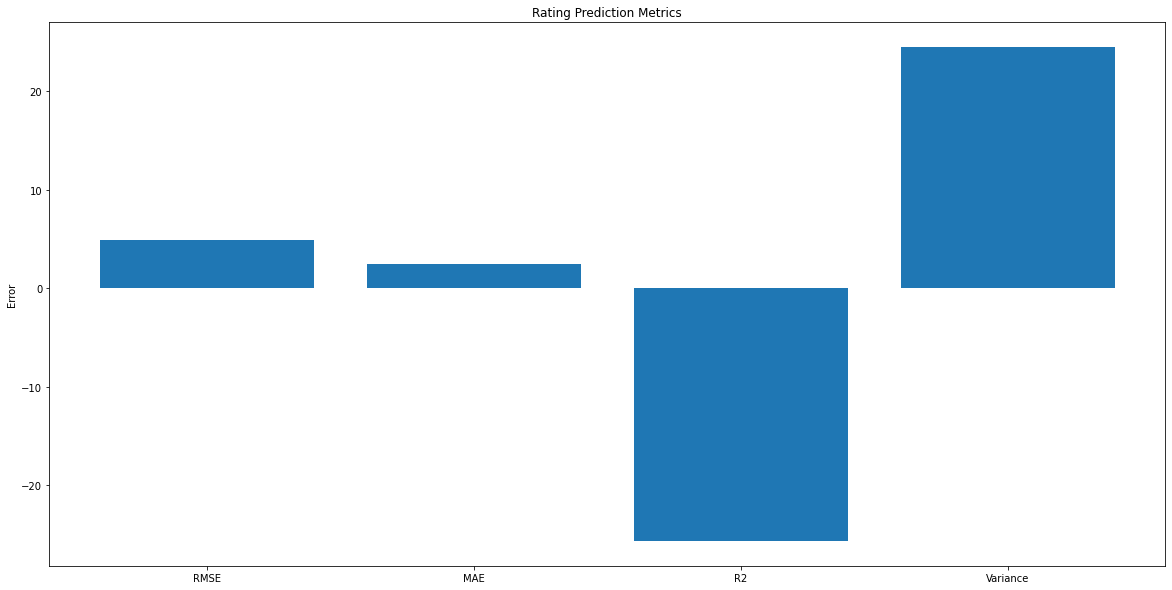

In [ ]:
# Print results
print("\nRating Prediction Metrics:")
print(f"RMSE: {results['rating_metrics']['rmse']:.4f}")
print(f"MAE: {results['rating_metrics']['mae']:.4f}")
print(f"R2: {results['rating_metrics']['r2_score']:.4f}")
print(f"Variance: {results['rating_metrics']['variance']:.4f}")

# Plot metrics
evaluator.plot_metrics(results)

# API

In [63]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
import uvicorn
import json
from datetime import datetime

# Pydantic models for request/response validation
class UserData(BaseModel):
    preferred_genres: Optional[List[str]] = Field(default=None, description="List of preferred genres")
    preferred_tags: Optional[List[str]] = Field(default=None, description="List of preferred tags")

class FeedbackData(BaseModel):
    user_id: str = Field(..., min_length=1, max_length=6, pattern=r"^(0|[1-9][0-9]*)$", description="User ID")
    item_id: int = Field(..., pattern=r"^(0|[1-9][0-9]*)$", description="Item ID")
    rating: float = Field(..., ge=0, le=5, description="Rating value between 0 and 5")
    user_movie_tags: Optional[str] = Field(default=None, min_length=1, max_length=50, description="User tags for the movie")
    recommendation_type: Optional[str] = Field(default="personalized", description="Type of recommendation")

class Recommendation(BaseModel):
    item_id: int
    title: str
    genres: str
    score: float
    rank: int

class RecommendationResponse(BaseModel):
    recommendations: List[Recommendation]
    metadata: Dict

app = FastAPI(
    title="Movie Recommender API",
    description="API for serving personalized movie recommendations",
    version="1.0.0"
)

# Global recommender instance
recommender = None

@app.on_event("startup")
async def startup_event():
    """Initialize recommender system on startup"""
    global recommender
    recommender = EnhancedRecommendationServer(
        recommendations_path='recommendation_data/recommendations.csv'
    )
    print("Recommender system initialized")

@app.get("/health")
async def health_check():
    """Check if the API is running"""
    return {"status": "healthy", "timestamp": datetime.now().isoformat()}

@app.get("/recommendations/{user_id}", response_model=RecommendationResponse)
async def get_recommendations(
    user_id: str,
    n_recommendations: int = 10,
    randomize: bool = True,
    user_data: Optional[UserData] = None
):
    """
    Get recommendations for a user
    
    Args:
        user_id: User identifier
        n_recommendations: Number of recommendations to return
        randomize: Whether to add random noise to scores
        user_data: Optional user preferences
    """
    try:
        recommendations = recommender.get_recommendations(
            user_id=user_id,
            n_recommendations=n_recommendations,
            randomize=randomize,
            user_data=user_data.dict() if user_data else None
        )
        return recommendations
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/feedback")
async def record_feedback(feedback: FeedbackData):
    """
    Record user feedback for a recommendation
    
    Args:
        feedback: Feedback data including user_id, item_id, rating, and optional tags
    """
    try:
        recommender.record_feedback(
            user_id=feedback.user_id,
            item_id=feedback.item_id,
            rating=feedback.rating,
            recommendation_type=feedback.recommendation_type,
            user_movie_tags=feedback.user_movie_tags
        )
        return {"status": "success", "message": "Feedback recorded successfully"}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/stats")
async def get_stats():
    """Get basic statistics about the recommender system"""
    return {
        "total_recommendations": len(recommender.recommendations_df),
        "total_users": len(recommender.user_recs.groups),
        "cold_start_recommendations": len(recommender.cold_start_recs),
        "timestamp": datetime.now().isoformat()
    }

if __name__ == "__main__":
    uvicorn.run("main:app", host="0.0.0.0", port=8003, reload=True)

INFO:     Will watch for changes in these directories: ['c:\\Users\\Pedro Alves\\Documents\\DS_Projects\\recommender_system_embeddings']
INFO:     Uvicorn running on http://0.0.0.0:8003 (Press CTRL+C to quit)
INFO:     Started reloader process [26936] using StatReload
INFO:     Stopping reloader process [26936]
